In [20]:
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [21]:
data = pd.read_csv("train.csv")
data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,2:-1], data.iloc[:,-1], random_state=42, test_size=0.2)

In [33]:
cat_features = ['key', 'mode', 'time_signature']
num_features = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms']
def encode_cat_features(df):
    df[cat_features] = df[cat_features].astype('category')
    return pd.get_dummies(df, columns=cat_features, drop_first=True)

X_train = encode_cat_features(X_train)
X_test = encode_cat_features(X_test)

In [34]:
train = pd.concat((X_train, y_train), axis=1)
# EDA
print(train.shape)
train.describe()

(14396, 26)


Popularity  danceability        energy      loudness   speechiness  \
count  14058.000000  14396.000000  14396.000000  14396.000000  14396.000000   
mean      44.657988      0.543513      0.663060     -7.930852      0.080275   
std       17.499543      0.166221      0.235115      4.070670      0.084958   
min        1.000000      0.059900      0.000020    -36.214000      0.022500   
25%       33.000000      0.432000      0.511000     -9.539250      0.034800   
50%       44.000000      0.546000      0.700000     -7.040500      0.047300   
75%       57.000000      0.659000      0.861000     -5.197000      0.083200   
max      100.000000      0.989000      1.000000      1.355000      0.955000   

       acousticness  instrumentalness      liveness       valence  \
count  14396.000000      10960.000000  14396.000000  14396.000000   
mean       0.246237          0.177131      0.196063      0.486498   
std        0.309697          0.303864      0.159638      0.240441   
min        0.000000          0.000001      0.011900      0.018300   
25%        0.004428          0.000088      0.097000      0.297000   
50%        0.081400          0.003885      0.129000      0.482000   
75%        0.431000          0.198000      0.258000      0.672000   
max        0.996000          0.996000      1.000000      0.986000   

              tempo  duration_in min/ms         Class  
count  14396.000000        1.439600e+04  14396.000000  
mean     122.606745        2.003162e+05      6.707836  
std       29.663698        1.112347e+05      3.192875  
min       30.557000        5.016500e-01      0.000000  
25%       99.370000        1.659455e+05      5.000000  
50%      120.041500        2.089735e+05      8.000000  
75%      142.022250        2.525308e+05     10.000000  
max      217.416000        1.477187e+06     10.000000

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14396 entries, 15758 to 15795
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Popularity          14058 non-null  float64
 1   danceability        14396 non-null  float64
 2   energy              14396 non-null  float64
 3   loudness            14396 non-null  float64
 4   speechiness         14396 non-null  float64
 5   acousticness        14396 non-null  float64
 6   instrumentalness    10960 non-null  float64
 7   liveness            14396 non-null  float64
 8   valence             14396 non-null  float64
 9   tempo               14396 non-null  float64
 10  duration_in min/ms  14396 non-null  float64
 11  key_2.0             14396 non-null  bool   
 12  key_3.0             14396 non-null  bool   
 13  key_4.0             14396 non-null  bool   
 14  key_5.0             14396 non-null  bool   
 15  key_6.0             14396 non-null  bool   
 16  key_7

<Axes: xlabel='Class', ylabel='Count'>

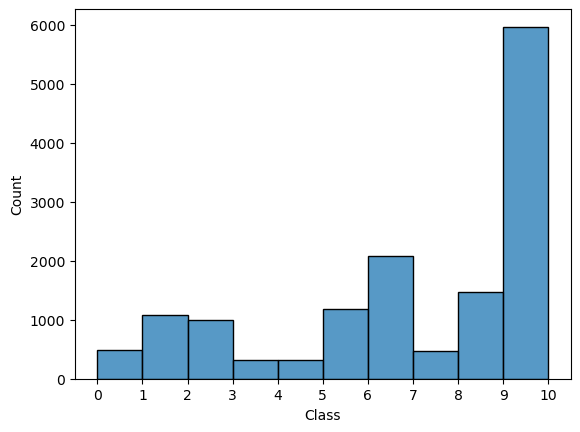

In [36]:
hist = sns.histplot(train['Class'], bins=10)
hist.set_xticks(range(11))
hist

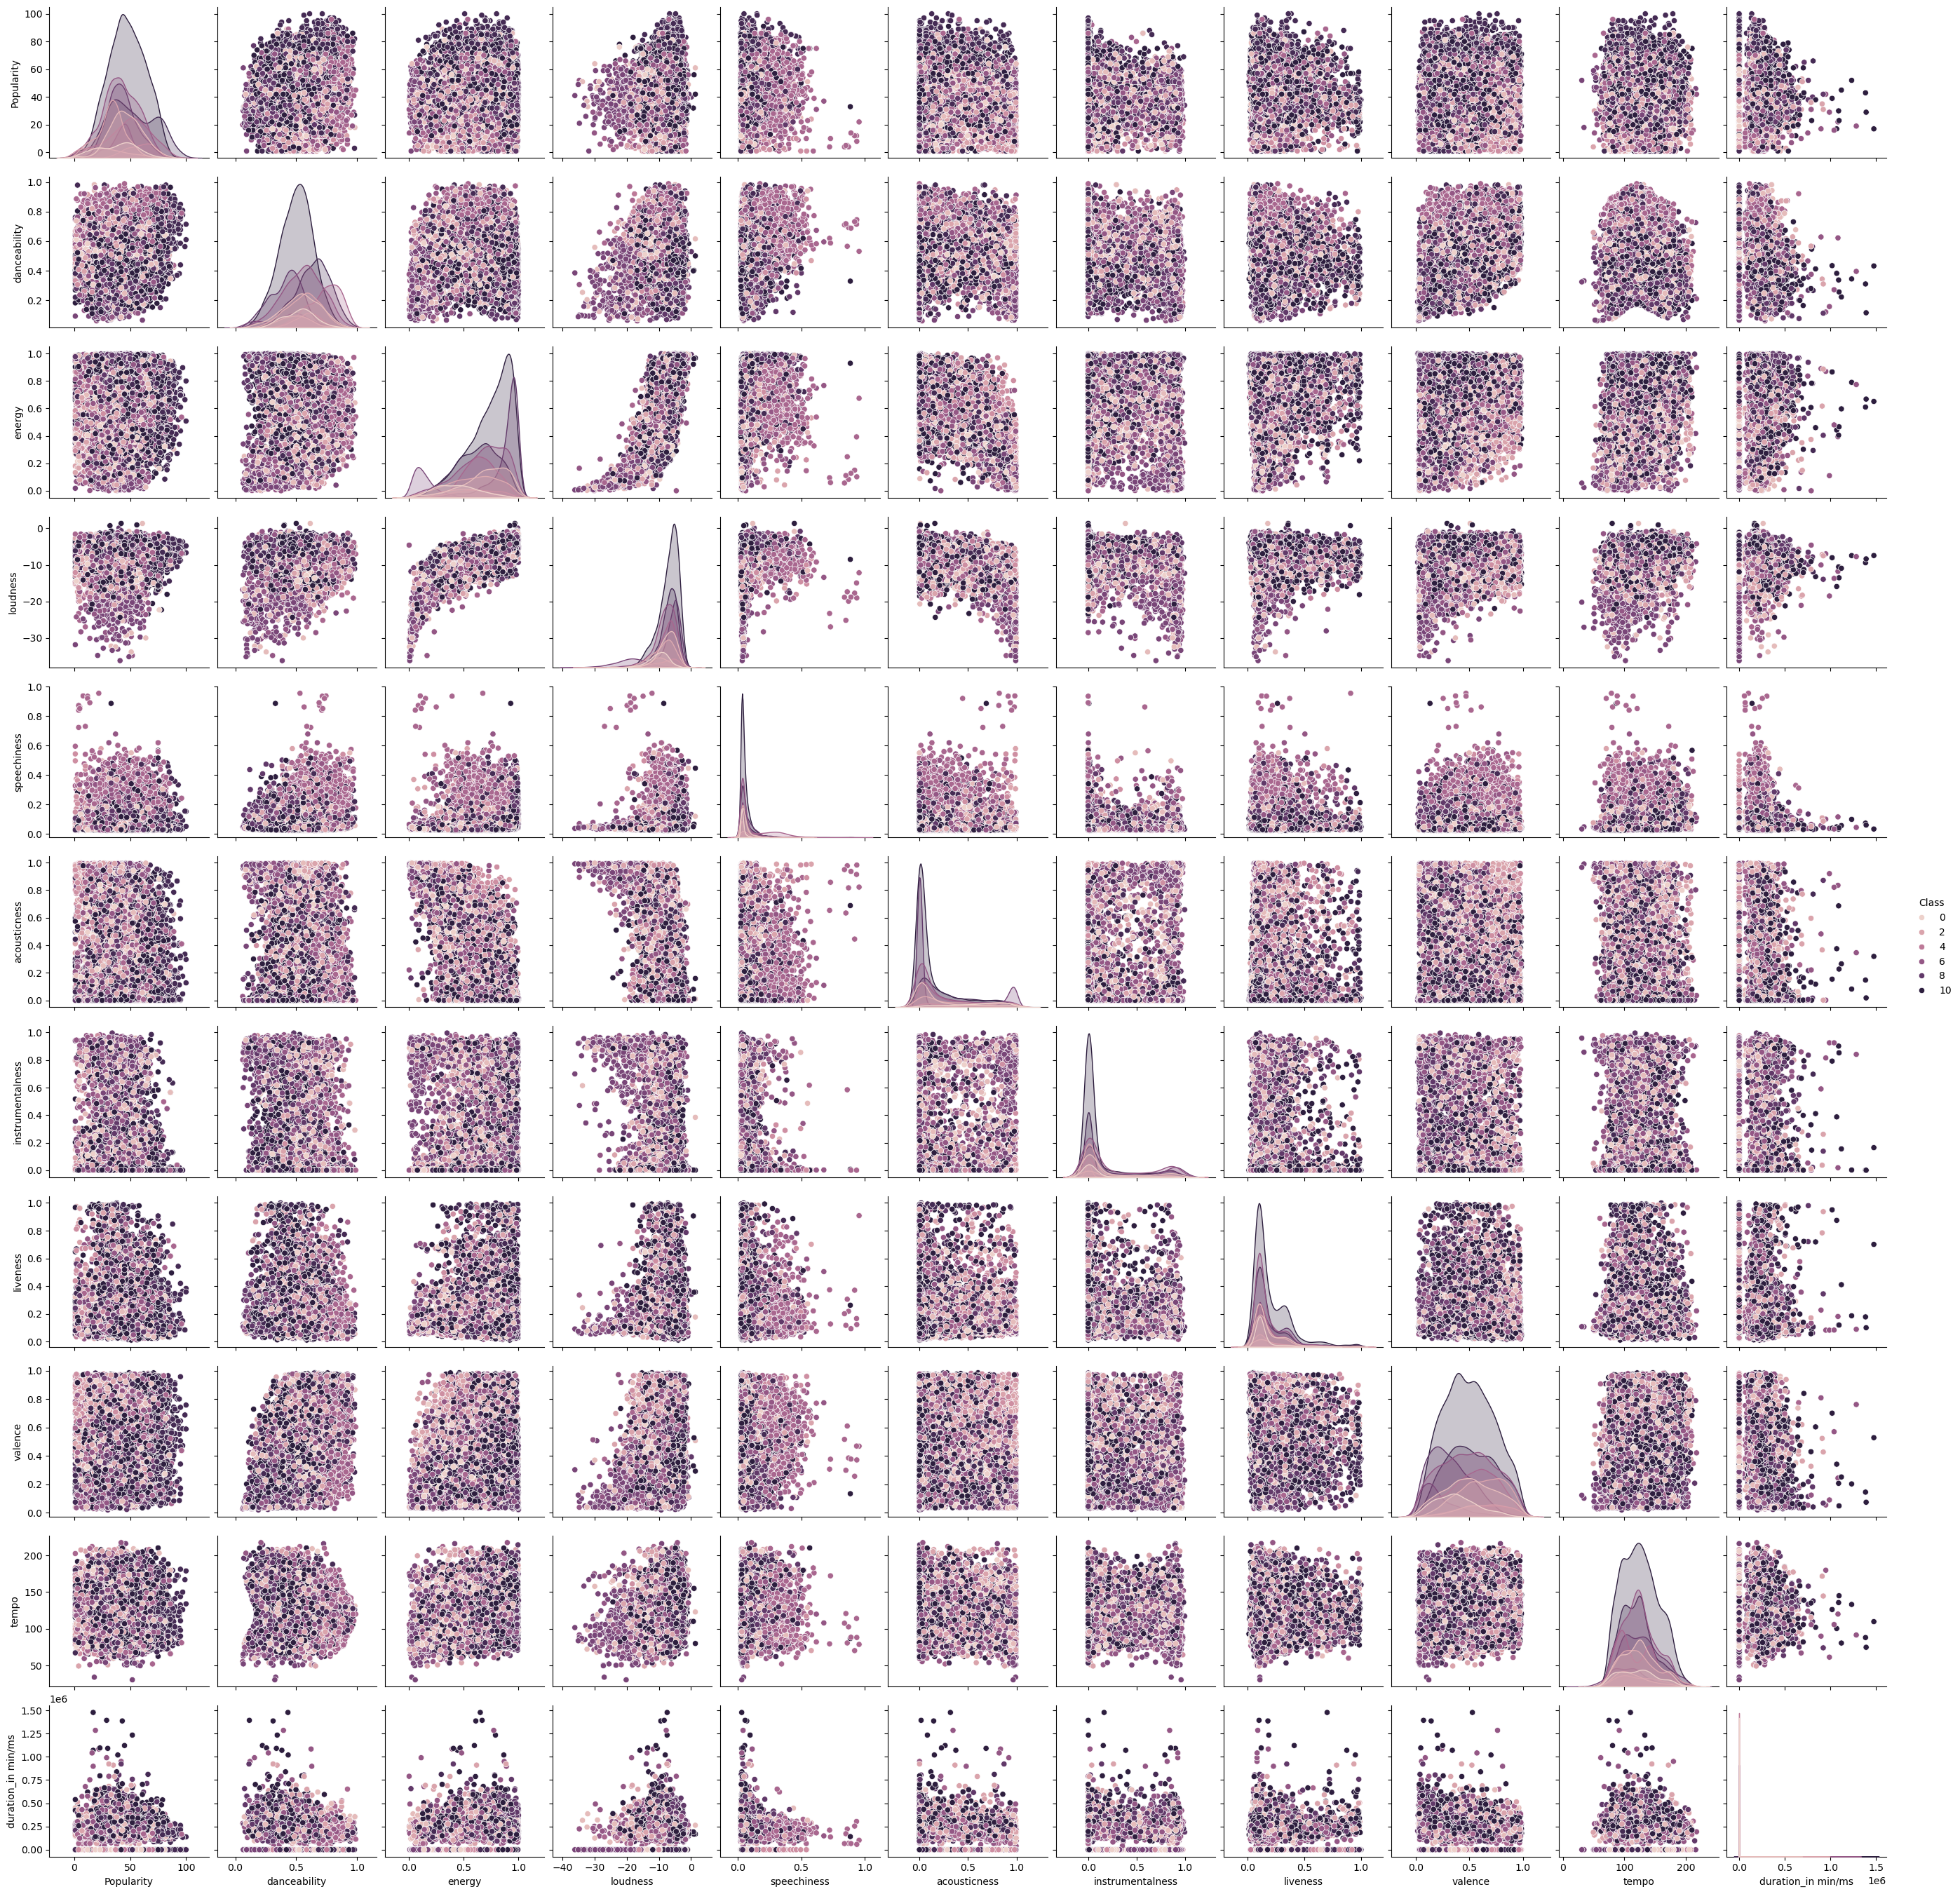

In [44]:
sns.pairplot(pd.concat((train[num_features],train['Class']),axis=1), hue='Class')

<Axes: >

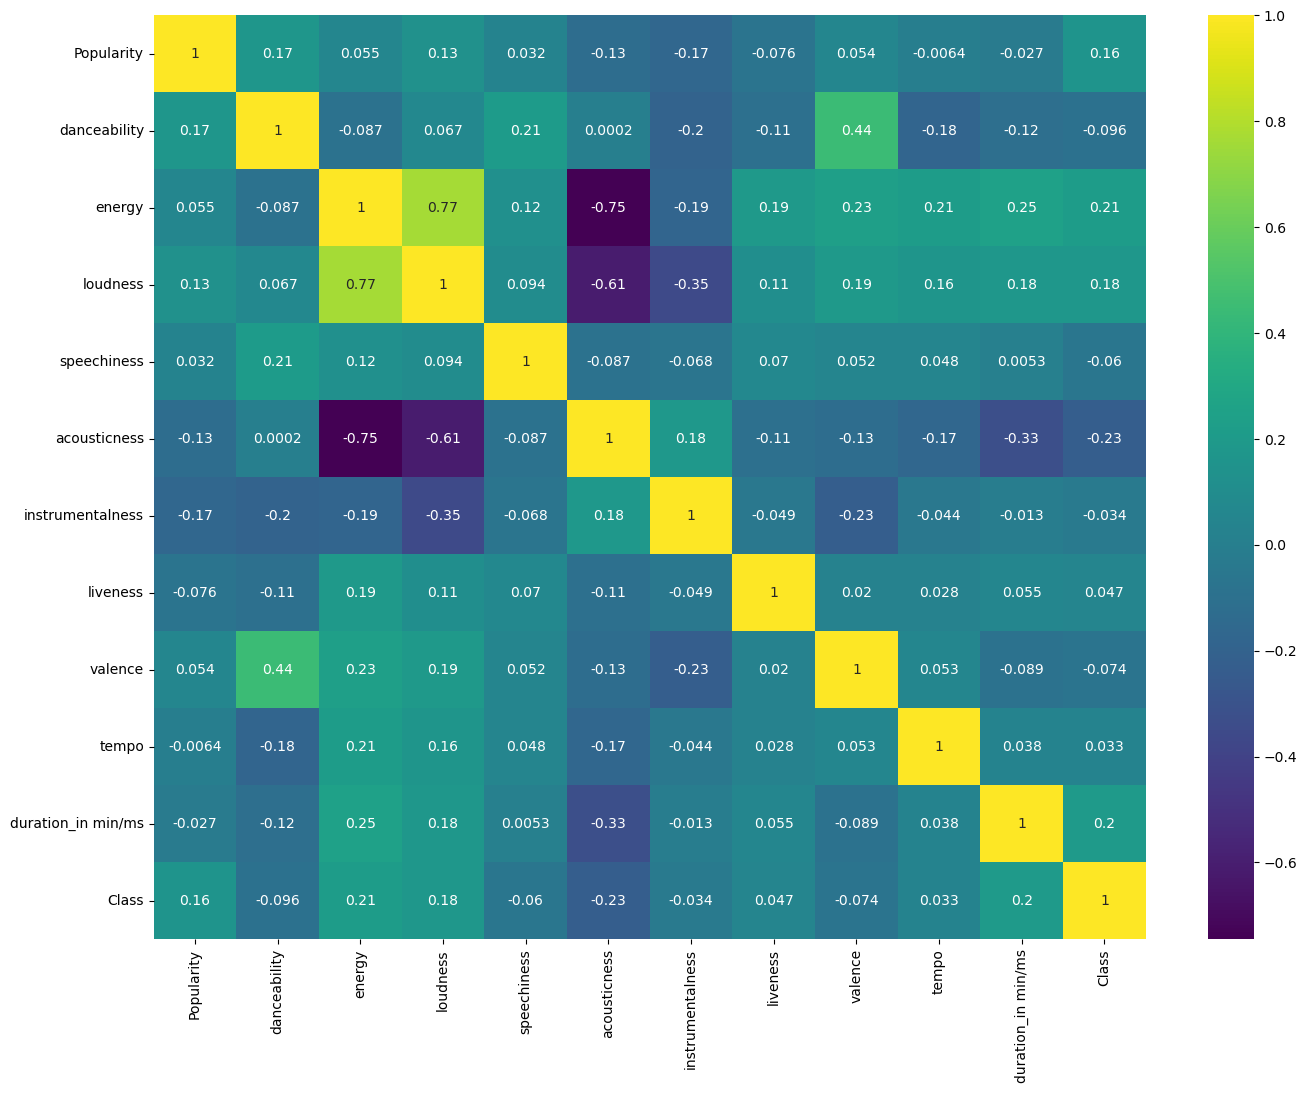

In [45]:
corr_matrix = pd.concat((train[num_features],train['Class']),axis=1).corr()
fig, ax = plt.subplots(figsize=(16,12))

sns.heatmap(corr_matrix, annot=True, cmap='viridis',ax=ax)

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def dtree_grid_search(X,y,nfolds=5):
    #create a dictionary of all values we want to test
    params = {
    'clf__max_depth': [5,20,100,150,200,250,300,400,500,1000],
    'clf__min_samples_leaf': [2,5,10,12,15]
    }

    # decision tree model
    clf_pipe = Pipeline([
    ('scaler', StandardScaler()),     
    ('clf', DecisionTreeClassifier()) 
    ])                                    

    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(clf_pipe, params, cv=nfolds, n_jobs=-1, scoring='f1_macro')
    #fit model to data
    dtree_gscv.fit(X, y)
    print(f'training: {classification_report(y, dtree_gscv.predict(X))}')
    print(f'test: {classification_report(y_test, dtree_gscv.predict(X_test))}')
    return dtree_gscv.best_params_

best_model = dtree_grid_search(X_train, y_train)

training:               precision    recall  f1-score   support

           0       0.68      0.74      0.71       489
           1       0.40      0.21      0.28      1087
           2       0.60      0.43      0.50       991
           3       0.76      0.72      0.74       324
           4       0.53      0.72      0.61       316
           5       0.72      0.70      0.71      1185
           6       0.54      0.46      0.50      2087
           7       0.96      0.89      0.93       473
           8       0.71      0.57      0.63      1472
           9       0.56      0.56      0.56      1993
          10       0.55      0.73      0.63      3979

    accuracy                           0.59     14396
   macro avg       0.64      0.61      0.62     14396
weighted avg       0.59      0.59      0.59     14396

test:               precision    recall  f1-score   support

           0       0.63      0.62      0.63       136
           1       0.17      0.09      0.12       286
        

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Интерстеллар
2. Жизнь других
3. Список Шиндлера